In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 64
NUM_CLASSES = 8  
EPOCHS = 100 
TRAIN_DATA_DIR = "/kaggle/input/affectnet/archive (3)/Train"
TEST_DATA_DIR = "/kaggle/input/affectnet/archive (3)/Test"
initial_learning_rate = 0.00025  

In [2]:
#Data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=[0.85, 1.15],  
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='rgb',
    classes=['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] 
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    classes=['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']  
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    classes=['Anger', 'Contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] 
)

Found 12890 images belonging to 8 classes.
Found 3218 images belonging to 8 classes.
Found 14518 images belonging to 8 classes.


In [3]:
def compute_class_weights(generator):
    class_counts = Counter()
    num_samples = generator.samples
    generator_iter = iter(generator)  
    for i in range(num_samples // BATCH_SIZE + 1):
        try:
            batch_x, batch_y = next(generator_iter)
            labels = np.argmax(batch_y, axis=1)
            class_counts.update(labels)
        except StopIteration:
            break
    total_samples = sum(class_counts.values())
    class_weights = {i: total_samples / (len(class_counts) * count) for i, count in class_counts.items()}
    return class_weights

In [4]:
def build_model():
    model = Sequential([
        Conv2D(128, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),  
        
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),  
        
        Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),  
        
        Conv2D(768, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Conv2D(768, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5), 
        
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Dropout(0.5),  
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    return model

Class weights: {6: 0.6515365952284674, 0: 1.3427083333333334, 3: 1.3316115702479339, 4: 0.8607104700854701, 7: 0.9500294811320755, 2: 1.63744918699187, 1: 1.291065705128205, 5: 0.7300634345265066}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 768)    │     3,539,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 768)    │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 768)    │     5,309,184 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,638,536 (52.03 MB)

 Trainable params: 13,631,368 (52.00 MB)

 Non-trainable params: 7,168 (28.00 KB)

Epoch 1/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.1437 - loss: 57.1884
Epoch 1: val_accuracy improved from -inf to 0.17063, saving model to /kaggle/working/emotiontask5.weights.h5
201/201 ━━━━━━━━━━━━━━━━━━━━ 181s 817ms/step - accuracy: 0.1437 - loss: 57.1366 - val_accuracy: 0.1706 - val_loss: 27.8883 - learning_rate: 2.5000e-04
Epoch 2/100
  1/201 ━━━━━━━━━━━━━━━━━━━━ 2:20 701ms/step - accuracy: 0.1719 - loss: 27.3897
Epoch 2: val_accuracy improved from 0.17063 to 0.17188, saving model to /kaggle/working/emotiontask5.weights.h5
201/201 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.1719 - loss: 27.3897 - val_accuracy: 0.1719 - val_loss: 27.8102 - learning_rate: 2.5000e-04
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.2059 - loss: 21.4045
Epoch 3: val_accuracy improved from 0.17188 to 0.30156, saving model to /kaggle/working/emotiontask5.weights.h5
201/201 ━━━━━━━━━━━━━━━━━━━━ 154s 768ms/step - accuracy: 0.2060 - loss: 21.3830 - val_accuracy:

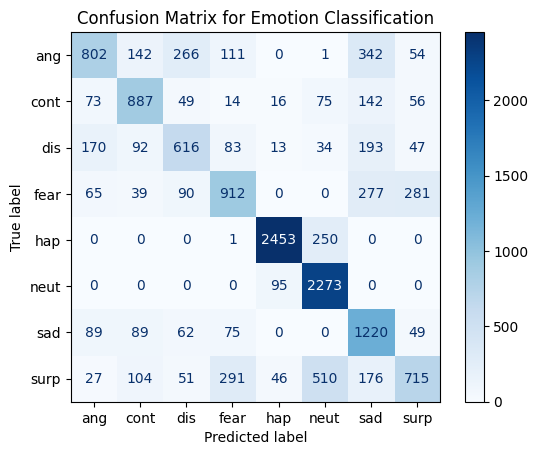

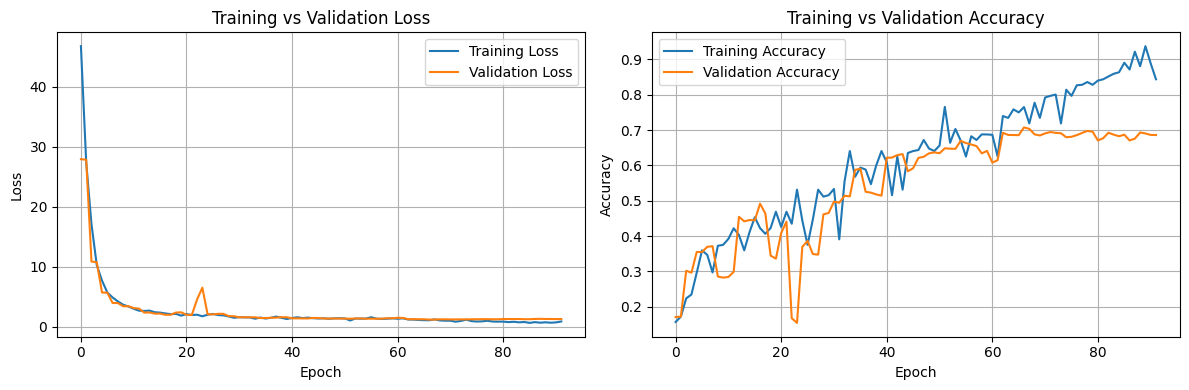

In [7]:
class_weights = compute_class_weights(train_generator)
print("Class weights:", class_weights)
model = build_model()

checkpoint = ModelCheckpoint(
    '/kaggle/working/emotiontask5.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights, 
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)
print("Loading best weights.")
model.load_weights("/kaggle/working/emotiontask5.weights.h5")

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
test_generator.reset()
y_true = []
y_pred = []
for i in range(test_generator.samples // BATCH_SIZE + 1):
    try:
        batch_x, batch_y = next(test_generator)
        y_true.extend(np.argmax(batch_y, axis=1))
        y_pred.extend(np.argmax(model.predict(batch_x, verbose=0), axis=1))
    except StopIteration:
        break
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

class_label=['ang', 'cont', 'dis', 'fear', 'hap', 'neut', 'sad', 'surp'] 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_label)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Emotion Classification')
plt.show()

model.save("/kaggle/working/emotiontask5.h5")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()